# Imports

In [53]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Dataset

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

# Base Model

In [3]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [4]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid(),  # todo: should have been sigmoid for RGB
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8

        out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
        out += feature640
        out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
        out += feature224
        out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
        out += feature80
        out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
        out += feature48
        out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
        out += feature32
        out = self.colorization_layers[7:10](
            out
        )  # 32x256x256 -> 64x256x256 -> 2x256x256

        return out

In [5]:
model = ConvNetWithEfficientNetFeatureExtractor().to("cuda")

# Inference

In [6]:
MODEL_NAME = "davis"
MODEL_DIR = Path("/home/salkhon/repo/colorization/models")

In [7]:
model.load_state_dict(torch.load(MODEL_DIR / f"{MODEL_NAME}.pth"))

<All keys matched successfully>

In [8]:
davis_bear_ds = ImageDataset(Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/bear"))

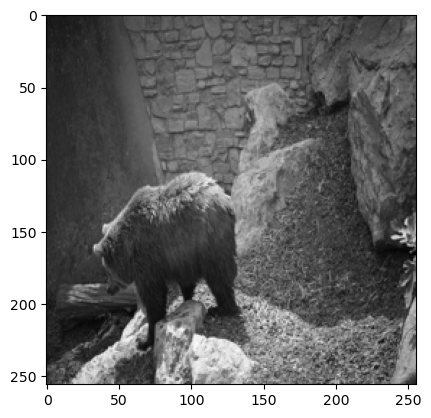

In [9]:
plt.imshow(davis_bear_ds[0][0].permute(1, 2, 0))

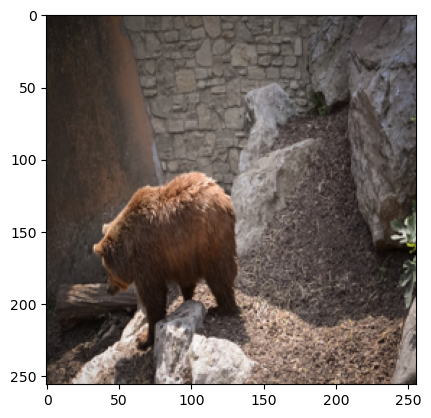

In [10]:
plt.imshow(davis_bear_ds[0][1].permute(1, 2, 0))

In [11]:
inp = davis_bear_ds[0][0].unsqueeze(0).to("cuda")
out = model(inp)

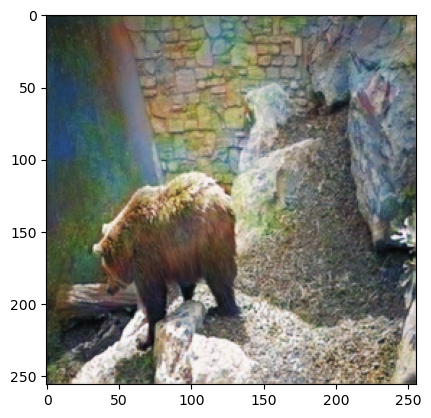

In [12]:
out: torch.Tensor
out = out.detach()[0].cpu()
plt.imshow(out.permute(1, 2, 0))

## Inference on DAVIS dataset

In [19]:
DAVIS_PATH = Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/")

OUTPUT_PATH = Path("/home/salkhon/repo/colorization/output") / MODEL_NAME
OUTPUT_PATH.mkdir(exist_ok=True)

In [40]:
davis_ds = ImageDataset(DAVIS_PATH)

In [15]:
for img_idx in tqdm(range(len(davis_ds))):
    inp = davis_ds[img_idx][0].unsqueeze(0).to("cuda")
    out = model(inp)
    out: torch.Tensor = out.detach()[0].cpu()
    inp_path = davis_ds.data_paths[img_idx]
    out_path = OUTPUT_PATH / inp_path.relative_to(DAVIS_PATH)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    transforms.ToPILImage()(out).save(out_path)

100%|██████████| 6208/6208 [26:49<00:00,  3.86it/s]


# Frame vs PSNR

In [50]:
# Function to compute PSNR between two images
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    mse = torch.mean((img1 - img2) ** 2)
    return (20 * torch.log10(1.0 / torch.sqrt(mse))).squeeze().item()

In [51]:
gt = davis_ds[0][1]
out = model(davis_ds[0][0].unsqueeze(0).to("cuda"))
out: torch.Tensor
out = out.detach()[0].cpu()
psnr_val = psnr(gt, out)
print(psnr_val)

22.74492073059082


### Category wise

In [18]:
dfs: dict[str, dict[str, list]] = {}
for img_idx in tqdm(range(len(davis_ds))):
    gt = davis_ds[img_idx][1]
    out_path = OUTPUT_PATH / davis_ds.data_paths[img_idx].relative_to(DAVIS_PATH)
    category = out_path.parent.name
    out = transforms.ToTensor()(Image.open(out_path))

    psnr_val = psnr(gt, out)

    if category not in dfs:
        dfs[category] = {"image": [], "psnr": []}

    dfs[category]["image"].append(out_path.name)
    dfs[category]["psnr"].append(psnr_val)

100%|██████████| 6208/6208 [02:45<00:00, 37.47it/s]


In [19]:
print(dfs)

{'crossing': {'image': ['00014.jpg', '00043.jpg', '00018.jpg', '00040.jpg', '00028.jpg', '00045.jpg', '00022.jpg', '00008.jpg', '00020.jpg', '00012.jpg', '00006.jpg', '00004.jpg', '00033.jpg', '00027.jpg', '00049.jpg', '00000.jpg', '00007.jpg', '00039.jpg', '00011.jpg', '00042.jpg', '00034.jpg', '00038.jpg', '00005.jpg', '00026.jpg', '00047.jpg', '00050.jpg', '00029.jpg', '00019.jpg', '00031.jpg', '00009.jpg', '00044.jpg', '00048.jpg', '00023.jpg', '00024.jpg', '00016.jpg', '00002.jpg', '00032.jpg', '00025.jpg', '00030.jpg', '00015.jpg', '00051.jpg', '00037.jpg', '00021.jpg', '00010.jpg', '00041.jpg', '00013.jpg', '00001.jpg', '00003.jpg', '00036.jpg', '00035.jpg', '00017.jpg', '00046.jpg'], 'psnr': [22.43529510498047, 22.82777976989746, 22.387638092041016, 22.706214904785156, 22.500526428222656, 23.005138397216797, 22.376060485839844, 22.427949905395508, 22.545778274536133, 22.46213722229004, 22.44462013244629, 22.44245719909668, 21.59330177307129, 22.607032775878906, 22.8933315277099

In [20]:
# save timeseries for each category
for category, data in dfs.items():
    df = pd.DataFrame(data, columns=["image", "psnr"])
    # save plot of psnr column over time
    df.plot(title=f"PSNR over time for {category}")
    plt.savefig(OUTPUT_PATH / category / f"{category}.png")
    plt.close()
    # save frame vs psnr values as csv
    df.set_index("image", inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(OUTPUT_PATH / category / f"{category}.csv")

### Frame wise

In [54]:
frames_vs_psnr: dict[str, dict[str, float]] = {}
for img_idx in tqdm(range(len(davis_ds))):
    gt = davis_ds[img_idx][1]
    out_path = OUTPUT_PATH / davis_ds.data_paths[img_idx].relative_to(DAVIS_PATH)
    out = transforms.ToTensor()(Image.open(out_path))

    psnr_val = psnr(gt, out)

    if out_path.name not in frames_vs_psnr:
        frames_vs_psnr[out_path.name] = {"psnr": psnr_val, "count": 1}

    frames_vs_psnr[out_path.name]["psnr"] += psnr_val
    frames_vs_psnr[out_path.name]["count"] += 1

100%|██████████| 6208/6208 [02:19<00:00, 44.41it/s]


In [55]:
df_dict = {"frame": [], "psnr": []}
for frame, data in frames_vs_psnr.items():
    df_dict["frame"].append(frame)
    df_dict["psnr"].append(data["psnr"] / data["count"])

df = pd.DataFrame(df, columns=["frame", "psnr"])

In [56]:
df.head()

,frame,psnr
0,00014.jpg,18.615908
1,00043.jpg,18.466837
2,00018.jpg,18.623435
3,00040.jpg,18.557150
4,00028.jpg,18.712379


In [57]:
df.tail()

,frame,psnr
99,00101.jpg,20.334419
100,00103.jpg,20.170055
101,00096.jpg,19.739960
102,00097.jpg,19.811978
103,00099.jpg,19.589546


In [ ]:
df.plot(title="Average PSNR over time")
plt.savefig(OUTPUT_PATH / "average_psnr.png")
plt.close()

# Color Distribution Consistency (CDC)

In [21]:
import scipy

def color_distribution_consistency(img1: torch.Tensor, img2: torch.Tensor) -> float:
    img1 = img1.permute(1, 2, 0).reshape(-1, 3)
    img2 = img2.permute(1, 2, 0).reshape(-1, 3)
    img1 = torch.mean(img1, dim=0)
    img2 = torch.mean(img2, dim=0)
    dist = scipy.spatial.distance.cdist(img1.unsqueeze(0), img2.unsqueeze(0)).flatten()[0]
    return dist

In [45]:
import numpy as np
import cv2


def compare_histograms(image1: torch.Tensor, image2: torch.Tensor, num_bins=256):
    # Convert tensors to NumPy arrays
    img1_np = image1.permute(1, 2, 0).cpu().numpy()
    img2_np = image2.permute(1, 2, 0).cpu().numpy()

    # Convert from RGB to HSV for better color representation
    img1_hsv = cv2.cvtColor(img1_np, cv2.COLOR_RGB2HSV)
    img2_hsv = cv2.cvtColor(img2_np, cv2.COLOR_RGB2HSV)

    # Calculate histograms for each channel
    hist1_h, _ = np.histogram(img1_hsv[:, :, 0], bins=num_bins)
    hist2_h, _ = np.histogram(img2_hsv[:, :, 0], bins=num_bins)
    hist1_s, _ = np.histogram(img1_hsv[:, :, 1], bins=num_bins)
    hist2_s, _ = np.histogram(img2_hsv[:, :, 1], bins=num_bins)
    hist1_v, _ = np.histogram(img1_hsv[:, :, 2], bins=num_bins)
    hist2_v, _ = np.histogram(img2_hsv[:, :, 2], bins=num_bins)

    # Compute CDC (Color Distribution Consistency) score
    cdc_h = 1 - (np.abs(hist1_h - hist2_h).sum() / hist1_h.sum())
    cdc_s = 1 - (np.abs(hist1_s - hist2_s).sum() / hist1_s.sum())
    cdc_v = 1 - (np.abs(hist1_v - hist2_v).sum() / hist1_v.sum())

    # Normalize the scores
    cdc_h = cdc_h / 255
    cdc_s = cdc_s / 255
    cdc_v = cdc_v / 255

    return (cdc_h + cdc_s + cdc_v) / 3

In [46]:
categories = [path.name for path in DAVIS_PATH.rglob("*")]
print(categories)

['crossing', 'hockey', 'mallard-fly', 'tuk-tuk', 'dogs-scale', 'motocross-bumps', 'mbike-trick', 'upside-down', 'boxing-fisheye', 'night-race', 'cat-girl', 'flamingo', 'cows', 'longboard', 'walking', 'india', 'schoolgirls', 'breakdance', 'sheep', 'bike-packing', 'goat', 'scooter-gray', 'breakdance-flare', 'rhino', 'bus', 'tennis', 'elephant', 'horsejump-low', 'dog-gooses', 'dance-jump', 'scooter-board', 'drift-straight', 'kite-walk', 'loading', 'bmx-trees', 'mallard-water', 'paragliding-launch', 'paragliding', 'stroller', 'car-shadow', 'planes-water', 'car-turn', 'shooting', 'skate-park', 'drift-chicane', 'bmx-bumps', 'drone', 'motocross-jump', 'dogs-jump', 'drift-turn', 'tractor-sand', 'car-roundabout', 'libby', 'dancing', 'surf', 'lindy-hop', 'rollerblade', 'classic-car', 'judo', 'hike', 'gold-fish', 'disc-jockey', 'blackswan', 'dance-twirl', 'train', 'bear', 'lucia', 'camel', 'horsejump-high', 'stunt', 'soapbox', 'miami-surf', 'swing', 'soccerball', 'boat', 'lab-coat', 'varanus-cage

In [48]:
cdc = 0
for category in categories:
    CAT_PATH = OUTPUT_PATH / category
    IMG_PATHS = sorted(CAT_PATH.rglob("*.jpg"))
    consecutive_pairs = zip(IMG_PATHS[:-1], IMG_PATHS[1:])
    for img1_path, img2_path in consecutive_pairs:
        img1 = transforms.ToTensor()(Image.open(img1_path))
        img2 = transforms.ToTensor()(Image.open(img2_path))
        cdc += compare_histograms(img1, img2)

cdc /= len(davis_ds)
print(cdc)

0.003109368641143073


# Film Clip Colorization

In [14]:
FILM_PATH = Path("/home/salkhon/repo/colorization/data/film/images")
FILM_OUTPUT_PATH  = Path("/home/salkhon/repo/colorization/output/film")

In [15]:
film_ds = ImageDataset(FILM_PATH)

In [16]:
len(film_ds)

300

In [18]:
for img_idx in tqdm(range(len(film_ds))):
    inp = film_ds[img_idx][0].unsqueeze(0).to("cuda")
    out = model(inp)
    out: torch.Tensor = out.detach()[0].cpu()
    inp_path = film_ds.data_paths[img_idx]
    out_name = inp_path.name
    # resize image to 1024x768 and save
    transforms.ToPILImage()(out).resize((1024, 768)).save(FILM_OUTPUT_PATH / out_name)

100%|██████████| 300/300 [01:22<00:00,  3.62it/s]
